In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# Load the pre-trained ResNet18 model and modify the last layer
resnet18 = torchvision.models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)  # CIFAR-10 has 10 classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}")

print("Finished training")

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")


Files already downloaded and verified
Files already downloaded and verified


c:\Users\dianu\anaconda3\envs\torcher\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dianu\anaconda3\envs\torcher\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\dianu/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:22<00:00, 2.09MB/s]


Epoch 1, Loss: 0.6129353814721108
Epoch 2, Loss: 0.24036929504573346
Epoch 3, Loss: 0.18599516393989324
Epoch 4, Loss: 0.15248792650550605
Epoch 5, Loss: 0.12876502646505833
Epoch 6, Loss: 0.11384207501262426
Epoch 7, Loss: 0.0983389961309731
Epoch 8, Loss: 0.08538726356998086
Epoch 9, Loss: 0.07661638939753175
Epoch 10, Loss: 0.06684405893646181
Finished training
Accuracy of the network on the 10000 test images: 94.56%


In [12]:
images.dtype

torch.float32

In [16]:
import numpy as np
#load inputer and outputer.npy
inputer = np.load('inputer.npy')
outputer = np.load('outputer.npy')

#convert to torch tensor
inputer = torch.from_numpy(inputer)
outputer = torch.from_numpy(outputer)

# resize the inputer to 224*224 through interpolation
inputer = torch.nn.functional.interpolate(inputer, size=(224,224), mode='bilinear', align_corners=False)
outputer= torch.nn.functional.interpolate(outputer, size=(224,224), mode='bilinear', align_corners=False)

resneter=resnet18.to('cpu')
out_inputer= resneter(inputer)
out_outputer= resneter(outputer)


In [ ]:
out_inputer=out_inputer.detach().numpy()
out_outputer=out_outputer.detach().numpy()

In [27]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    similarity = dot_product / (norm_vec1 * norm_vec2)
    
    return similarity

profile = []

for i in range(0,100):
    profile.append(cosine_similarity(out_inputer[i], out_outputer[i]))

# calculate the mean of the profile
mean_profile = np.mean(profile)

# calculate the standard deviation of the profile
std_profile = np.std(profile)

std_threshold = 0.1

if std_profile < std_threshold:
    print("The model is possibly giving poisonned outputs")

else:
    print("The model is not giving poisonned outputs")

The model is not giving poisonned outputs


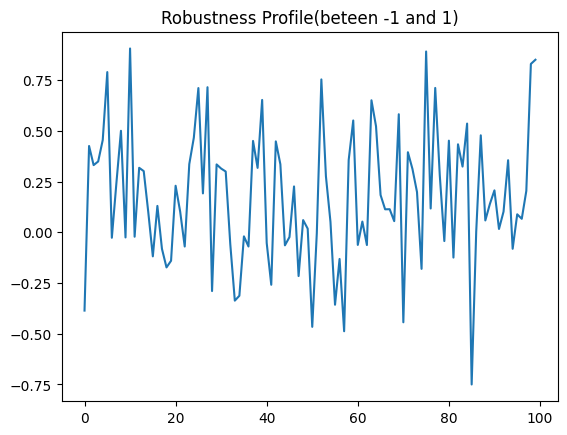

In [29]:
#plot the profile
import matplotlib.pyplot as plt
plt.plot(profile)
plt.title("Robustness Profile(beteen -1 and 1), mean: "+str(mean_profile)+", std: "+str(std_profile))
plt.show()